# 0. Preparation

+ Data Description:  
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

## 0.1 Import module

In [1]:
# data frame
import pandas as pd
import numpy as np

# plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# stats
from scipy.stats import norm
from scipy import stats

# sklearn
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as linear_model

# else
import warnings
warnings.filterwarnings('ignore')

## 0.2 Load data

In [135]:
train_df = pd.read_csv('raw_data/train.csv')

## 0.3 Identify quantitvtive and qualitative data

In [4]:
quantitative = [f for f in train_df.columns if train_df.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train_df.columns if train_df.dtypes[f] == 'object']

In [6]:
print(quantitative)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [7]:
print(qualitative)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


# 1. Exploration data

## 1.1 Statistics property of target (SalePrice)

In [9]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

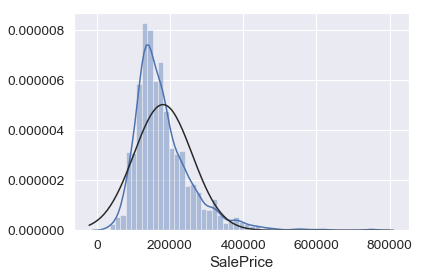

In [112]:
# historgram
sns.distplot(train_df['SalePrice'], fit = norm)

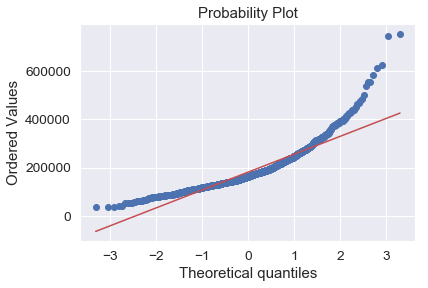

In [115]:
res = stats.probplot(train_df['SalePrice'], plot=plt)

+ it seems that saleprice is not a normal distribution，let's do more test about it

In [12]:
print("Skewness: {}".format(train_df['SalePrice'].skew()))
print("Kurtosis: {}".format(train_df['SalePrice'].kurt()))

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


### 1.1.1 Check normality

In [25]:
def normality_check(df, col_name):
    normality = stats.shapiro(df[col_name])
    print("Shapiro test: {}".format(normality[0]))
    print("p_value < 0.01: {}".format(normality[1] < 0.01))

+ Doesn't pass the normality test, the SalePrice is not a normal distribution

In [26]:
# Shapiro-Wilk test
normality_check(train_df, 'SalePrice')

Shapiro test: 0.869671642780304
p_value < 0.01: True


#### 1.1.1.1 Data transform
As the SalePrice is not normal distribution, we use log transform

In [136]:
train_df['SalePrice_log'] = np.log(train_df['SalePrice'])

+ plot the transformed data

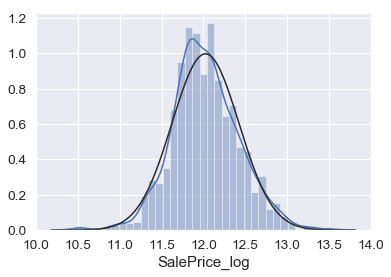

In [111]:
sns.distplot(train_df['SalePrice_log'], fit = norm)

In [122]:
normality_check(train_df, 'SalePrice_log')

Shapiro test: 0.9912577867507935
p_value < 0.01: True


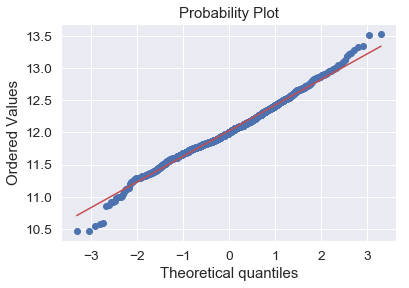

In [116]:
res = stats.probplot(train_df['SalePrice_log'], plot=plt)

## 1.2 Relationship

### 1.2.1 with numerical variables

#### 1.2.1.1 Correlation matrix [all the numerical variables]
a quick overview of our dataset and its relationships
+ ps: using spearman corr since the data is not normal distrubation

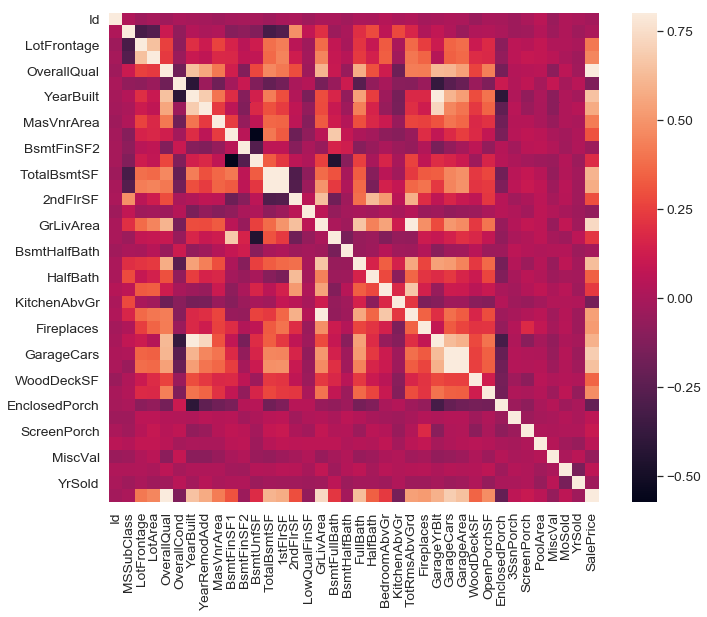

In [44]:
corrmat = train_df.corr(method = 'spearman')
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corrmat, vmax = 0.8, square = True)

+ zoomed correlation matrix  
the variables most correlated with 'SalePrice'

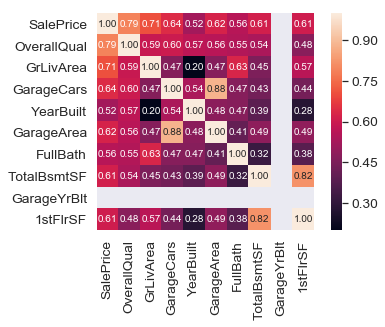

In [45]:
#saleprice correlation matrix

k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### 1.2.1.2 scatter plot [single feature vs SalePrice]
Define a function to plot the scatter plot of feature and SalePrice to see their relationship

In [14]:
def plot_scatter(df, x, y = 'SalePrice'):
    data = pd.concat([df[x],df[y]], axis = 1)
    data.plot.scatter(x = x, y = y, ylim = (0, 1.2* max(df[y])))

+ from the scatter plot, we can see that GrLivArea seems to have a linear relation with SalePrice

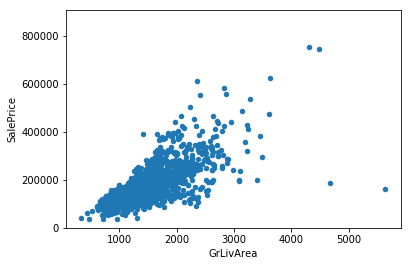

In [15]:
plot_scatter(train_df, 'GrLivArea')

### 1.2.2 with categorical features

#### 1.2.2.1 Anova [all the categorical variables]
quick estimation of influence of categorical variable on SalePrice.
calucate anova for each feature, and sort by each p-value

In [68]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

ano_value = anova(train_df)
ano_value['disparity'] = np.log(1./ano_value['pval'].values)

In [69]:
ano_value.head(10)

,feature,pval,disparity
8,Neighborhood,1.558600e-225,517.637858
18,ExterQual,1.439551e-204,469.363028
30,KitchenQual,3.032213e-192,440.987045
20,Foundation,5.791895e-91,207.778784
27,HeatingQC,2.667062e-67,153.292224
42,SaleCondition,7.988268e-44,99.235770
15,Exterior1st,2.586089e-43,98.061012
16,Exterior2nd,4.842186e-43,97.433793
41,SaleType,5.039767e-42,95.091214
0,MSZoning,8.817634e-35,78.413725


#### 1.2.2.2 box plot [single feature vs SalePrice]
Define a function to plot the box plot of feature and SalePrice to see their relationship

In [16]:
def plot_box(df,x,y = 'SalePrice'):
    data = pd.concat([df[x],df[y]], axis = 1)
    sns.boxplot(x = x, y = y, data = data)
    x = plt.xticks(rotation = 90)

+ seems that higher the OverallQual, higher the SalePrice

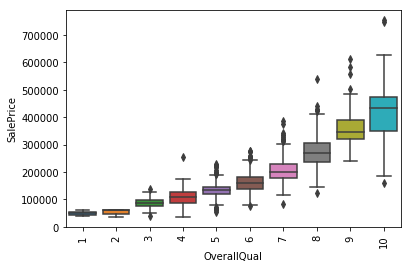

In [18]:
plot_box(train_df, 'OverallQual')

### 1.2.3 with all variable
encoded qualitative variables according to ordering based on mean of SalePrice
show the correlation map with encoded value

In [70]:
train_encode_df = train_df.copy()

def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature] = o
    
for q in qualitative:  
    encode(train_encode_df, q)

now we have a df with all the qualitative vaiable encoded

In [71]:
train_encode_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,4,65.0,8450,2,NaN,1,2,2,...,0,NaN,NaN,NaN,0,2,2008,5,5,208500
1,2,20,4,80.0,9600,2,NaN,1,2,2,...,0,NaN,NaN,NaN,0,5,2007,5,5,181500
2,3,60,4,68.0,11250,2,NaN,2,2,2,...,0,NaN,NaN,NaN,0,9,2008,5,5,223500


the top 10 most correlated with SalePrice using spearman corr

In [72]:
spr = pd.DataFrame()
spr['feature'] = train_encode_df.columns.drop('SalePrice')
spr['spearman'] = [train_encode_df[f].corr(train_encode_df['SalePrice'], 'spearman') for f in spr['feature']]
spr['spearman_abs'] = np.absolute(spr['spearman'])
spr = spr.sort_values('spearman_abs', ascending  = False)
spr.head(10)    

,feature,spearman,spearman_abs
17,OverallQual,0.809829,0.809829
12,Neighborhood,0.755779,0.755779
46,GrLivArea,0.731310,0.731310
61,GarageCars,0.690711,0.690711
27,ExterQual,0.684014,0.684014
53,KitchenQual,0.672849,0.672849
30,BsmtQual,0.664393,0.664393
19,YearBuilt,0.652682,0.652682
62,GarageArea,0.649379,0.649379
49,FullBath,0.635957,0.635957


# 2. Clean up data

## 2.1 Missing data
19 attributes have missing values, 5 over 50% of all data. Most of times NA means lack of subject described by attribute, like missing pool, fence, no garage and basement.

In [137]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageQual,81,0.055479
GarageCond,81,0.055479
GarageFinish,81,0.055479
GarageType,81,0.055479


If we want to delete data, what's the rule, and will we missing important information?
+ if missing rate > 15%, delete the data:
> we will delete: PollQC, MiscFeature, Alley, Fence, FireplaceQu, LotFrontage

+ will we missing important imformation?
> go back to use plot to check  
> but base on the overall correlation, none of those features are very important

+ delete feature that correlated with other feature we already consider or has no missing value:
> GargageX and BsmtX which we have other feature (with no missing value) to represent them

+ delete feature that is highly correlate with the value we considered, because they provide similar information
> MasVnrArea, MasVnrType have a strong correlation with 'YearBuilt' and 'OverallQual' which are already considered.

Result: we only keep Electrical which has only one missing value, we can either delete the observation or fill it with mean/medium
> delete the observation

In [138]:
feature_drop = list(missing_data[missing_data['Total'] > 1].index)     

In [139]:
# dealing with missing data
train_df = train_df.drop(feature_drop, axis = 1)
train_df = train_df.drop(train_df.loc[train_df['Electrical'].isnull()].index)

In [140]:
# checking that there's no more missing data 
train_df.isnull().sum().max() 

0

## 2.2 Outliers

### 2.2.1 Univariate analysis: 
standardize the data 

using StandarScaler().fit_transform to standardizing data,   
the feature pass to this function should be a 2D array, so use [:,np.newaxis] to transform it

In [141]:
# standardizing data
saleprice_scaled = StandardScaler().fit_transform(train_df['SalePrice'][:,np.newaxis])
trans_price = sorted(saleprice_scaled) # now it's a 2D array, sorted by standarded saleprice
trans_price = np.reshape(trans_price, len(trans_price)) # turn in to 1D array

In [142]:
# showing the lower limit and higher limit
print(trans_price[:10])
print(trans_price[-10:])

[-1.83820775 -1.83303414 -1.80044422 -1.78282123 -1.77400974 -1.62295562
 -1.6166617  -1.58519209 -1.58519209 -1.57269236]
[3.82758058 4.0395221  4.49473628 4.70872962 4.728631   5.06034585
 5.42191907 5.58987866 7.10041987 7.22629831]


+ observation:  
low range values are similar and not too far from 0.  
high range values are far from 0. like higher above 5 of std, we should pay attention on them

### 2.2.2 Bivariate analysis:
use scater plot to see if there are wierd pattern 

#### GrLivArea vs SalePrice

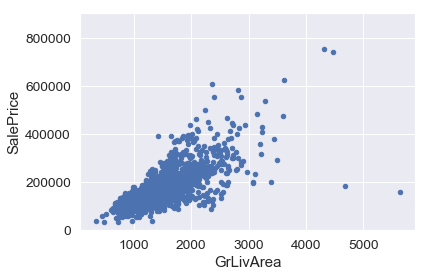

In [97]:
plot_scatter(train_df, 'GrLivArea')

+ observation:


> The two values with bigger 'GrLivArea' seem strange and they are not following the crowd.  
>> We can speculate why this is happening.   
Maybe they refer to agricultural area and that could explain the low price.   
I'm not sure about this but I'm quite confident that these two points are not representative of the typical case. 
Therefore, we'll define them as outliers and delete them.

> The two observations in the top of the plot are those 7.something observations that we said we should be careful about. They look like two special cases, however they seem to be following the trend. For that reason, we will keep them.

In [143]:
# find these two values
train_df[ train_df['GrLivArea'] > 4000][train_df['SalePrice'] < 500000]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_log
523,524,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,10,2007,New,Partial,184750,12.126759
1298,1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,...,0,0,480,0,1,2008,New,Partial,160000,11.982929


In [144]:
train_df = train_df.drop(train_df[train_df['Id'] == 1299].index)
train_df = train_df.drop(train_df[train_df['Id'] == 524].index)

+ look at the plot again, it look better, like a linear relationship

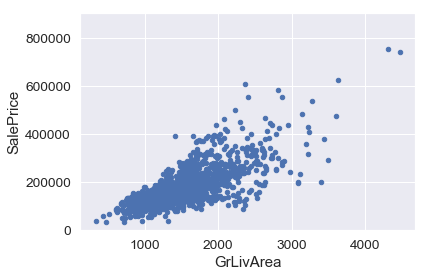

In [145]:
plot_scatter(train_df, 'GrLivArea')

#### TotalBsmtSF vs SalePrice

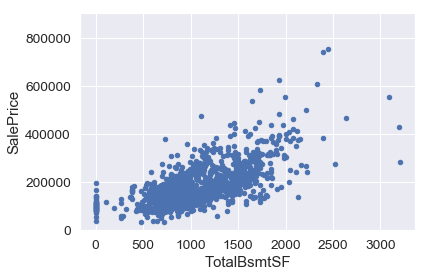

In [146]:
plot_scatter(train_df, 'TotalBsmtSF')

## 2.3 Statistical assumptions for important feature
focus on GrLivArea and TotalBsmtSF

+ GrLivArea

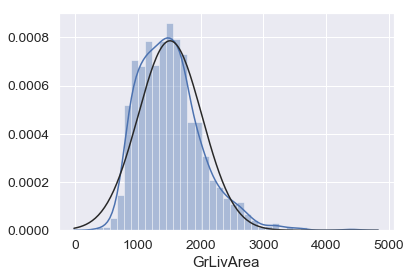

In [117]:
sns.distplot(train_df['GrLivArea'], fit=norm);

In [118]:
# Shapiro-Wilk test
normality_check(train_df, 'GrLivArea')

Shapiro test: 0.9500929117202759
p_value < 0.01: True


In [147]:
# log transformation
train_df['GrLivArea_log'] = np.log(train_df['GrLivArea'])

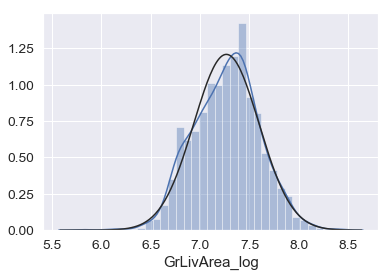

In [148]:
sns.distplot(train_df['GrLivArea_log'], fit=norm);

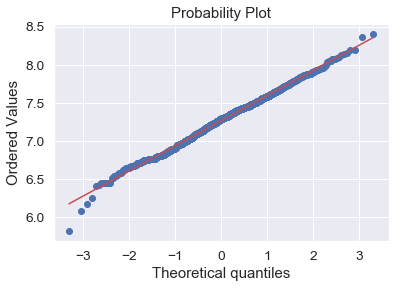

In [124]:
res = stats.probplot(train_df['GrLivArea_log'], plot=plt)

+ TotalBsmtSF

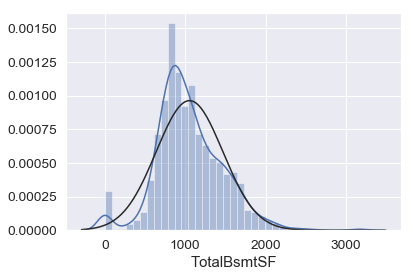

In [149]:
sns.distplot(train_df['TotalBsmtSF'], fit=norm);

In [126]:
# Shapiro-Wilk test
normality_check(train_df, 'TotalBsmtSF')

Shapiro test: 0.9650983810424805
p_value < 0.01: True


problem:
> A significant number of observations with value zero (houses without basement).  
and value zero doesn't allow us to do log transformations.

solution:
> create a variable that can get the effect of having or not having basement (binary variable)  
 do a log transformation to all the non-zero observations, ignoring those with value zero.

In [150]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0

train_df['HasBsmt'] = pd.Series(len(train_df['TotalBsmtSF']), index=train_df.index)
train_df['HasBsmt'] = 0 
train_df.loc[train_df['TotalBsmtSF']>0,'HasBsmt'] = 1

In [154]:
#transform data
train_df.loc['TotalBsmtSF_log'] = np.log(train_df['TotalBsmtSF'])

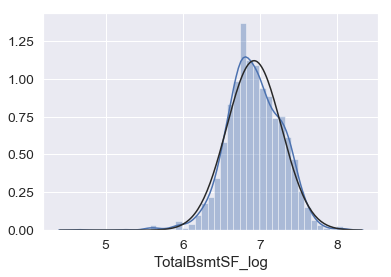

In [155]:
sns.distplot(train_df[train_df['HasBsmt']==1]['TotalBsmtSF_log'], fit=norm)

# 3 Dummy variables

In [ ]:
#convert categorical variable into dummy
train_df = pd.get_dummies(train_df)